Periodogram peaks above a power of 0.6: [ 1.43723176  3.29133525  3.71997207]
mass ratio is  0.643986286319 +/- 6.93427691827e-05


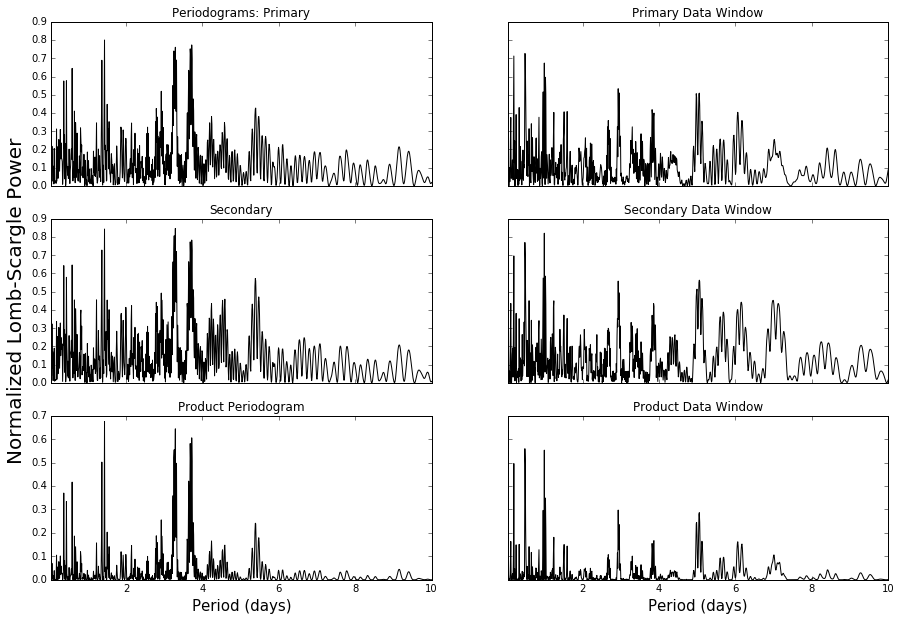

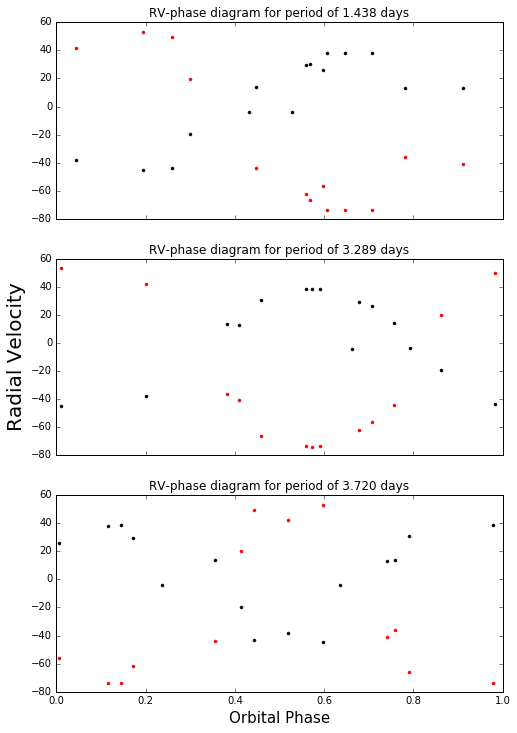

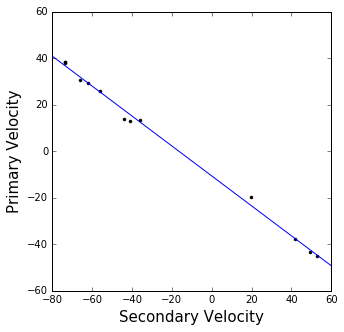

In [1]:
#import-libraries-and-data---------------------------------------------------------------------------------------#
import time
import emcee
import corner
import numpy as np
import functions as f
from scipy import stats
from matplotlib import pyplot as plt
from scipy.signal import lombscargle
from scipy.optimize import curve_fit
%matplotlib inline
filename     = '2M17204248+4205070.tbl'
system       = np.genfromtxt(filename, skip_header=1, usecols=(0, 1, 2))

#define-variables------------------------------------------------------------------------------------------------#

JD, RVp, RVs = [datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs     = JD, JD
samples      = 1000
max_period   = 10

#define-functions------------------------------------------------------------------------------------------------#

periodogram = f.periodogram
dataWindow  = f.dataWindow
maxima      = f.maxima
phases      = f.phases
massRatio   = f.massRatio
adjustment  = f.adjustment
RV          = f.RV
residuals   = f.residuals
constraints = f.constraints
alteredRV   = f.alteredRV

#now-do-things!--------------------------------------------------------------------------------------------------#

#check RV measurements for the need to be adjusted and adjust them if so
for i in range(0, len(JD)-1):
    if np.isnan(system[i][1]):
        JDp, RVp = adjustment(JD, RVp)
        break
        
for i in range(0, len(JD)-1):
    if np.isnan(system[i][2]):
        JDs, RVs = adjustment(JD, RVs)
        break
        
# plot the results
x, y  = periodogram(JDp, RVp, samples, max_period)
y2    = periodogram(JDs, RVs, samples, max_period)[1]
y3,y4 = dataWindow(JDp, samples, max_period)[1], dataWindow(JDs, samples, max_period)[1]

fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, sharex='col', sharey='row')
ax1.plot(x, y, 'k')
ax1.set_title('Periodograms: Primary')
ax1.set_xlim(1/24, max_period)
ax4.set_xlim(1/24, max_period)
ax2.plot(x, y2, 'k')
ax2.set_title('Secondary')
ax3.plot(x, y*y2, 'k')
ax3.set_title('Product Periodogram')
ax4.plot(x, y3, 'k')
ax4.set_title('Primary Data Window')
ax5.plot(x, y4, 'k')
ax5.set_title('Secondary Data Window')
ax6.plot(x, y3*y4, 'k')
ax6.set_title('Product Data Window')
ax3.set_xlabel('Period (days)', size='15')
ax6.set_xlabel('Period (days)', size='15')
ax2.set_ylabel('Normalized Lomb-Scargle Power', size='20')
fig.set_figheight(10)
fig.set_figwidth(15)
#plt.savefig(filename + ' periodogram.pdf')
print('Periodogram peaks above a power of 0.6:',maxima(0.6, x, y, y2))

fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1, sharex='col', sharey='row')
ax1.plot(phases(maxima(0.6, x, y, y2)[0], 0, JDp), RVp, 'k.')
ax1.plot(phases(maxima(0.6, x, y, y2)[0], 0, JDs), RVs, 'r.')
ax1.set_title('RV-phase diagram for period of 1.438 days')
ax2.plot(phases(maxima(0.6, x, y, y2)[1], 0, JDp), RVp, 'k.')
ax2.plot(phases(maxima(0.6, x, y, y2)[1], 0, JDs), RVs, 'r.')
ax2.set_title('RV-phase diagram for period of 3.289 days')
ax3.plot(phases(maxima(0.6, x, y, y2)[2], 0, JDp), RVp, 'k.')
ax3.plot(phases(maxima(0.6, x, y, y2)[2], 0, JDs), RVs, 'r.')
ax3.set_title('RV-phase diagram for period of 3.720 days')
ax3.set_xlabel('Orbital Phase', size='15')
ax2.set_ylabel('Radial Velocity', size='20')
fig.set_figheight(12)
fig.set_figwidth(8)
#plt.savefig(filename + ' RV-phase diagram.pdf')

mass_ratio, intercept, r_squared, standard_error, slope_error = massRatio(RVs,RVp, system)
p = [datum[1] for datum in system if not np.isnan(datum[1]+datum[2])]
s = [datum[2] for datum in system if not np.isnan(datum[1]+datum[2])]
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.plot(s, p, 'k.')
ax.plot(np.array([-80, 60]), -mass_ratio*np.array([-80, 60])+intercept)
ax.set_ylabel('Primary Velocity', size='15')
ax.set_xlabel('Secondary Velocity', size='15')
print('mass ratio is ', mass_ratio, "+/-", slope_error)

/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater


Completed in  6  minutes and  43 seconds.


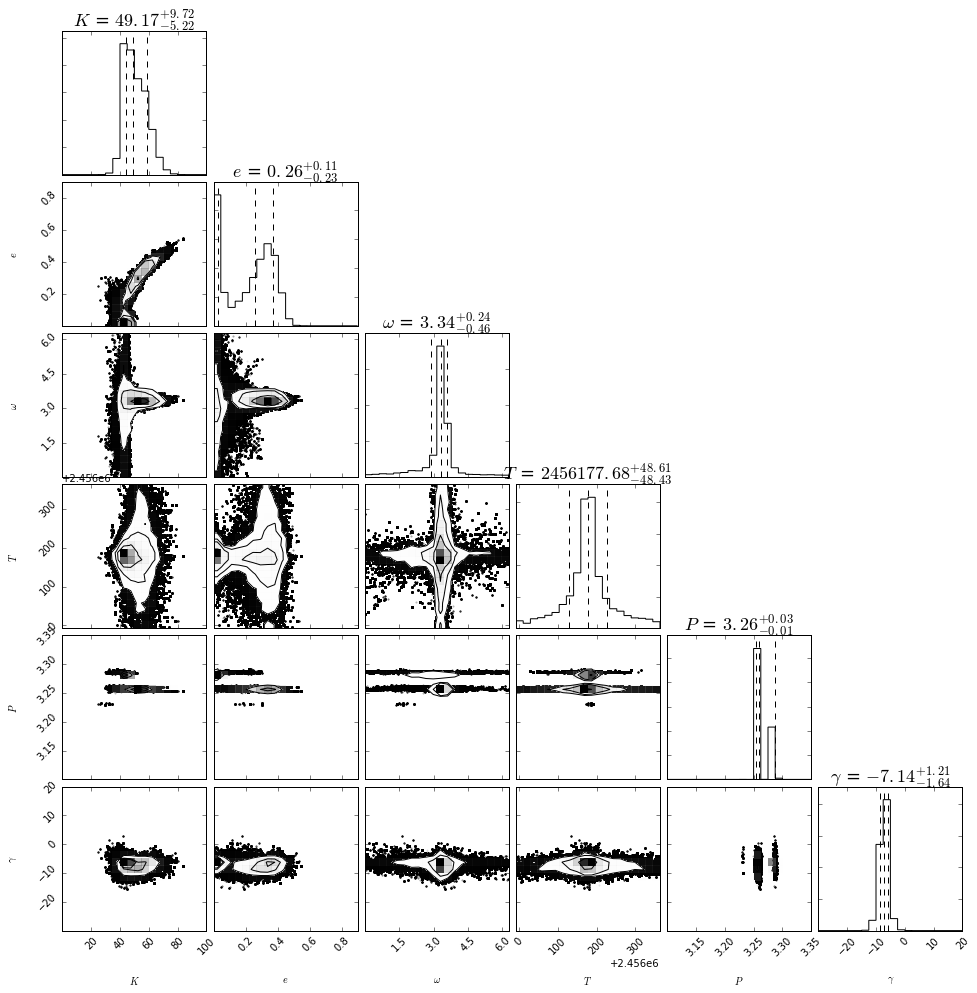

In [6]:
t0 = time.time()

lower_bounds = [0, 0, 0, JD[0], 3.1, -30]
upper_bounds = [100, 0.9, 2*np.pi, JD[-1], 3.35, 20]

def initialGuess(lower, upper):
    return curve_fit(alteredRV, JDp, np.asarray(RVp), bounds=(lower, upper))[0]

initial_guess = initialGuess(lower_bounds, upper_bounds)

def likelihood(parameters, mass_ratio, primary, secondary):
    r = np.sqrt(sum((np.asarray(primary)-RV(JDp, mass_ratio, parameters)[0])**2)
        +sum((np.asarray(secondary)-RV(JDs, mass_ratio, parameters)[1])**2))
    return -r

#function is poorly named, returns the negative infinity if parameters lie outside contraints, otherwise
#returns the output from residuals()
def probability(initial_guess, mass_ratio, RVp, RVs, lower, upper):
    con = constraints(initial_guess, lower, upper)
    if not np.isfinite(con):
        return -np.inf
    return con + likelihood(initial_guess, mass_ratio, RVp, RVs)

#set dimensionality and walker number
ndim, nwalkers, nsteps = 6, 400, 10000

#initialize walkers 
position = [initial_guess + 0.1*np.random.randn(ndim) for i in range(nwalkers)]

#walkers distributed in gaussian ball around most likely parameter values
for i in range(0, nwalkers-1):
    position[i][0] = initial_guess[0] + 2.5*np.random.randn(1) #K
    position[i][1] = initial_guess[1] + 0.1*np.random.randn(1) #e
    position[i][2] = initial_guess[2] + 1  *np.random.randn(1) #w
    position[i][3] = initial_guess[3] + 5  *np.random.randn(1) #T
    position[i][4] = initial_guess[4] +0.01*np.random.randn(1) #P
    position[i][5] = initial_guess[5] + 3  *np.random.randn(1) #y


sampler = emcee.EnsembleSampler(nwalkers, ndim, probability,
                                args=(mass_ratio, RVp, RVs, lower_bounds, upper_bounds), threads = 4)
sampler.run_mcmc(position, nsteps)

#create the corner plot
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$K$", "$e$", "$\omega$", "$T$", "$P$", "$\gamma$"],
                    extents=[[lower_bounds[0], upper_bounds[0]], [lower_bounds[1],upper_bounds[1]],
                             [lower_bounds[2], upper_bounds[2]],
                             [lower_bounds[3], upper_bounds[3]], [lower_bounds[4], upper_bounds[4]],
                             [lower_bounds[5], upper_bounds[5]]],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})
#fig.savefig("triangle.png")

t = time.time()
print('Completed in ', int((t-t0)/60), ' minutes and ', int(((t-t0)/60-int((t-t0)/60))*60), 'seconds.')

(0, 1)

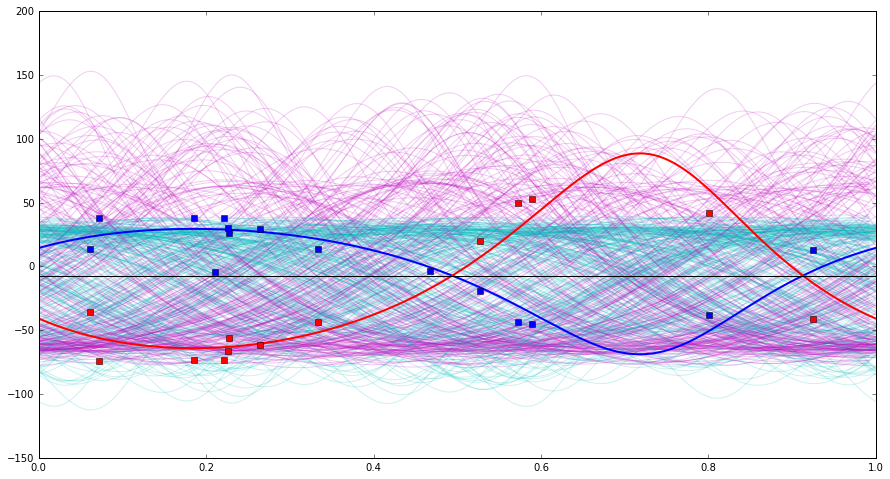

In [7]:
x = np.linspace(0, 3.26, num=1000)
plt.figure(figsize=(15,8))
for K, e, w, T, P, y in samples[np.random.randint(len(samples), size=250)]:
    parameters = K, e, w, T, P, y
    primary, secondary = RV(x, mass_ratio, parameters)
    plt.plot(x/parameters[4],   primary, 'c',  label='Potential Primary Curves', alpha=0.2)
    plt.plot(x/parameters[4], secondary, 'm',  label='Potential Secondary Curves', alpha=0.2)

#plt.plot(x/parameters[4], RV(x, mass_ratio, initial_guess)[0], color="b", lw=2) #initial guess curve

primary, secondary = RV(x, mass_ratio, [49.17, 0.26, 3.34, 2456177.68, 3.26, -7.14])
plt.plot(x/3.26,   primary,         'b', lw=2)
plt.plot(x/3.26, secondary,         'r', lw=2)
plt.plot(x, np.ones(len(x))*-7.14,  'k' ,      label='Systemic Velocity')
plt.plot(phases(3.26, 0, JDp), RVp, 'bs',      label='Primary RV Data') #data phased to result period
plt.plot(phases(3.26, 0, JDs), RVs, 'rs',      label='Secondary RV data')
plt.xlim(0,1)
#plt.ylim(-24.28,72.84)

#plt.savefig('results.pdf')